## Лабораторная работа 3 - Байесовская оптимизация

## Построение регрессии с помощью Гауссовского процесса

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import seaborn as sbs

### Генерация выборки

Ответ на очередном объекте $x_i$ генерируется следующим образом:

$$t_i = f(x_i)+\varepsilon_i, \; \varepsilon_i \sim \mathcal{N}(0,\sqrt{2})$$

In [ ]:
def f(x):
    return -8*np.sin(x)

support = np.arange(-1.0, 11.0, 1e-2)

In [ ]:
X_train = np.arange(0,10.0,0.5)
X_train = X_train.reshape([len(X_train), -1])
Y_train = f(X_train)
T_train = Y_train+2*np.random.randn(*X_train.shape)

X_test = support
X_test = X_test.reshape([len(X_test), -1])

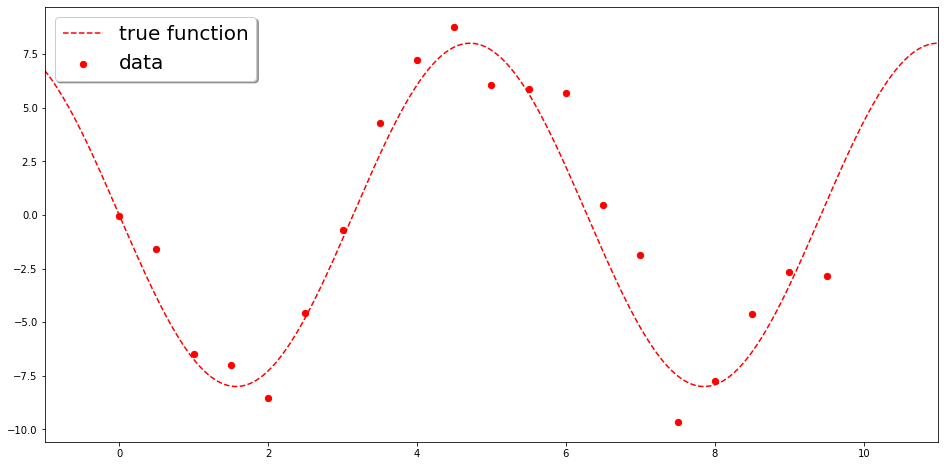

In [ ]:
figsize(16,8)
plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
plt.plot(support, f(support), '--r', label='true function')
plt.legend(fontsize=20, frameon=True, shadow=True)
plt.xlim(np.min(support), np.max(support))
plt.show()

### Предсказание

В тестовой точке $x$ мы можем предсказать два параметра – мат. ожидание $\mu(x)$ и стандартное отклонение $\sigma(x)$.
Для заданной ковариационной функции $k(x,y)$ и для заданной дисперсии случайного шума $\beta^{-1}$, $\mu(x), \sigma(x)$ вычисляются по следующим формулам:

$$\mu(x) = \mathbf{k}^TC_N^{-1}\mathbf{t}, \;\;\;\; \sigma^2(x) = k(x,x)+\beta^{-1}-\mathbf{k}^TC_N^{-1}\mathbf{k},$$

где $\mathbf{k} = k(x_i, x)$ – вектор, состоящий из элементов $k(x_i, x), \; i=1,\ldots,N$,  
$\mathbf{t} = (t_1,\ldots,t_N)$ – вектор ответов на обучающей выборке,  
$С_N = \mathbf{K} + \beta^{-1}E$, где $\mathbf{K}_{ij} = k(x_i,x_j)$ – ковариационная матрица.

Примеры ковариационных функций:
- $K(x,y) = C$ – константная,
- $K(x,y) = \sum_{j=1}^d\theta_jx_jy_j$ – линейная,
- $K(x,y) = \exp(-\sum_{j=1}^d\theta_j(x_j-y_j)^2)$  – экспоненциальная,
- $K(x,y) = \exp(-\sum_{j=1}^d\theta_j|x_j-y_j|)$ – процесс Орнштейна-Уленбека.

**1.** Реализуте функции вычисления ковариационных матриц между двумя произвольными выборками объектов, а затем функцию, вычисляющую предсказание в новой точке. Циклы использовать запрещено.

In [ ]:
def linear_k(X, Y, theta):
    # your code here
    return np.sum(X[:, :, None] * (Y * theta[None, :]).T[None, :, :], axis=1)
    
def rbf_k(X, Y, theta):
    # your code here
    return np.sum(np.exp(-theta[None, :, None] * (X[:, :, None] - Y.T[None, :, :]) ** 2), axis=1)

def ou_k(X, Y, theta):
    # your code here
    return np.sum(np.exp(-theta[None, :, None] * np.abs(X[:, :, None] - Y.T[None, :, :])), axis=1)

def predict(X_train, T_train, X_test, theta, beta, kernel):
    # your code here
    K = kernel(X_train, X_train, theta)
    k = kernel(X_train, X_test, theta)
    K_new = kernel(X_test, X_test, theta)
    C_N = K + (1 / beta) * np.eye(X_train.shape[0])
    inv_C_N = np.linalg.inv(C_N)
    mu = np.dot(np.dot(k.T, inv_C_N), T_train)
    sigma = K_new + (1 / beta) - np.dot(np.dot(k.T, inv_C_N), k)
    return mu, np.sqrt(np.diag(sigma))

In [ ]:
def plot_result():
    figsize(16,8)
    plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
    plt.plot(support, f(support), '--r', label='true function')
    plt.plot(X_test, mu_test.reshape((mu_test.shape[0],)), c='b', label='mu test')
    plt.fill_between(X_test.flatten(), mu_test.reshape((mu_test.shape[0],))-sigma_test, mu_test.reshape((mu_test.shape[0],))+sigma_test, color='b', label='confidence', alpha=0.3)
    plt.legend(fontsize=20, frameon=True, shadow=True)
    plt.xlim(np.min(support), np.max(support))

### Экспоненциальная ковариационная функция

In [ ]:
theta = np.array([1.0])
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

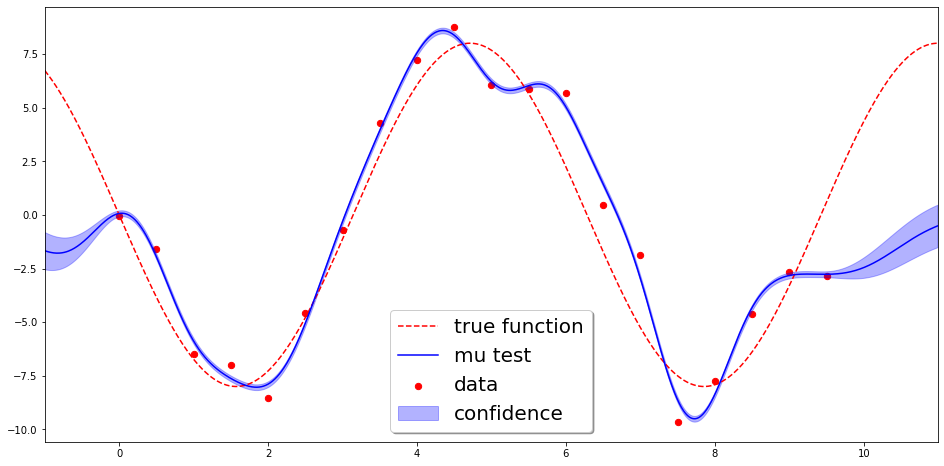

In [ ]:
plot_result()

Посмотрим как ведёт себя регрессия для разных значений $\beta$

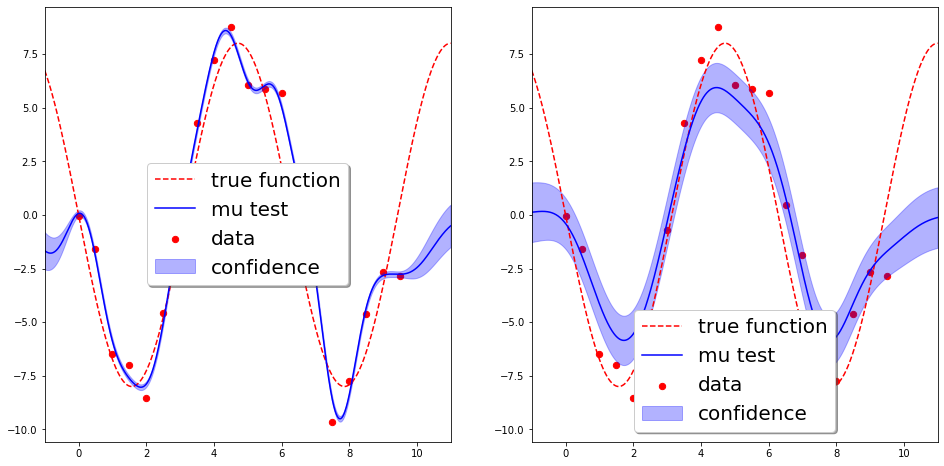

In [ ]:
plt.subplot(121)
theta = np.array([1.0])
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
plot_result()
plt.subplot(122)
theta = np.array([1.0])
beta = 1.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)
plot_result()

Запишите что вы пронаблюдали и как можно интерпретировать параметр $\beta$.  
(_пункт не оценивается_)

Судя по наблюдениям, можно предположить, что параметр $\beta$ является в определенном смысле коэффициентом регуляризации, контролирует, как сильно гауссовский процесс будет настраиваться на известные наблюдения (чем больше $\beta$, тем сильнее процесс подстраивается под данные). Если рассмотреть формулу $C_N=K+\beta^{-1}E$, то можно сказать, что $\beta$ контролирует степень учета шумовой составляющей. Варьируя его, можно будет адаптировать гауссовский процесс под различные данные.

### Линейная ковариационная функция

In [ ]:
theta = np.array([1.0])
beta = 100.0
kernel = linear_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

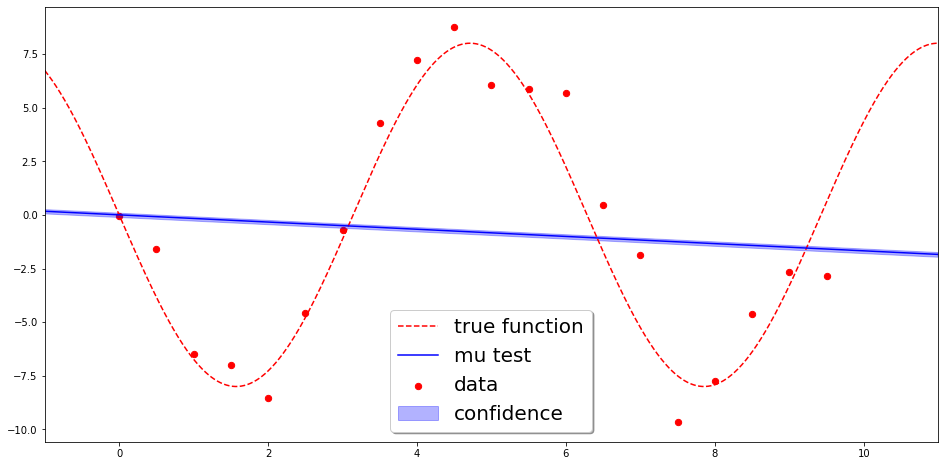

In [ ]:
plot_result()

### Ковариационная функция Орнштейна-Уленбека

In [ ]:
theta = np.array([1.0])
beta = 100.0
kernel = ou_k
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

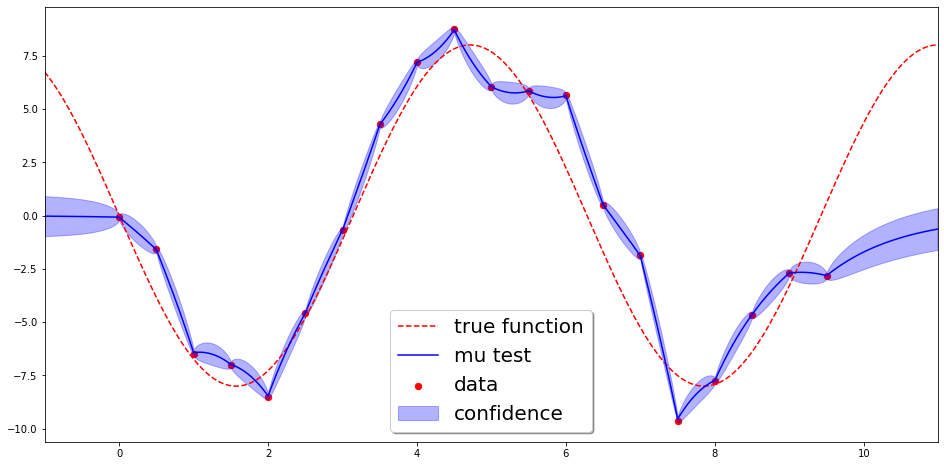

In [ ]:
plot_result()

На практике часто прибегают к смеси ковариационных функций, чтобы добиться определённых свойств регрессии.

In [ ]:
theta = np.array([1.0])
beta = 10.0
kernel = lambda X,Y,theta: ou_k(X,Y,theta) + rbf_k(X,Y,theta)
mu_test, sigma_test = predict(X_train, T_train, X_test, theta, beta, kernel)

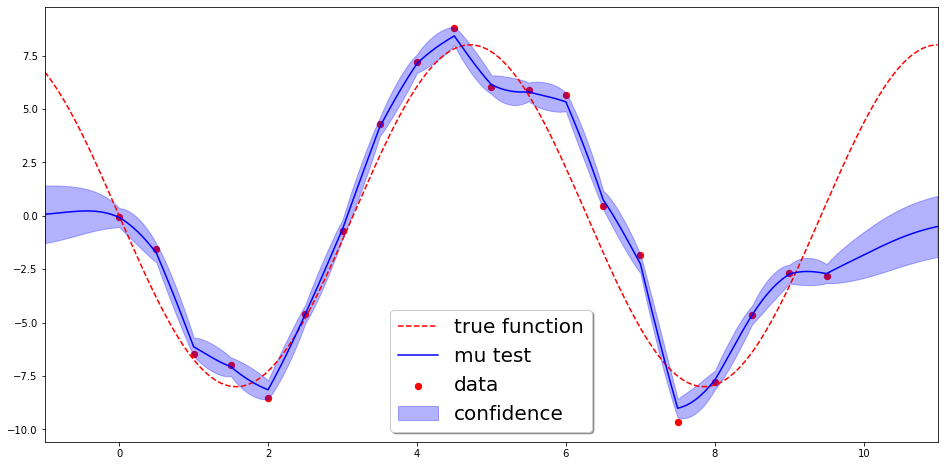

In [ ]:
plot_result()

### Подбор параметров

Подбор параметров $\theta$ для произвольного ядра можно сделать максимизируя логарифм правдоподобия на обучающей выборке:

$$\log p(\mathbf{t}|\theta) = -\frac{1}{2}\log|C_N| - \frac{1}{2}\mathbf{t}^TC_N^{-1}\mathbf{t} - \frac{N}{2}\log(2\pi) \to \max_{\theta}.$$

Максимизировать заданный функционал мы будем с помощью градиентного подъёма. Однако, мы будем проводить оптимизацию по $\log\theta$ (т.е. считать градиенты относительно $\log\theta$ и обновлять $\log\theta$, а не сами $\theta$), поскольку так процесс проще сходится

Вам пригодится формула для градиента по $\theta$:

$$\frac{\partial}{\partial \theta_j}\log p(\mathbf{t}|\theta) = -\frac{1}{2}\text{Tr}\bigg(C_N^{-1}\frac{\partial C_N}{\partial \theta_j}\bigg) + \frac{1}{2}\mathbf{t}^TC_N^{-1}\frac{\partial C_N}{\partial \theta_j}C_N^{-1}\mathbf{t}$$

**2.** 

  а) Получите формулу для расчёта градиента логарифма правдоподобия по $\log\theta$ 


  $\log p(t|\theta) = -\frac{1}{2}\log|C_N| - \frac{1}{2}t^TC_N^{-1}t - \frac{N}{2}\log(2\pi) \to \max_{\theta}.$

Рассмотрим поэлементное дифференцирование. Применим правило вычисления производной сложной функции.

$\frac{\partial \log p(t\mid \theta)}{\partial \log \theta_j}=\frac{\partial \log p(t\mid \theta)}{\partial \theta_j} \frac{\partial \theta_j}{\partial \log \theta_j}=\theta_j \left( -\frac{1}{2}tr\left(C_N^{-1}\frac{\partial C_N}{\partial \theta_j}\right)+\frac{1}{2}t^TC_N^{-1}\frac{\partial C_N}{\partial \theta_j}C_N^{-1}t\right).$


$С_N = K + \beta^{-1}E,\quad K_{ml}=k(x_m,x_l) = e^{-\sum_{j=1}^d\theta_j(x_{mj}-x_{lj})^2}\Rightarrow\\\Rightarrow \frac{\partial C_N}{\partial \theta_j}=\frac{\partial K}{\partial \theta_j}$

Отметим, что $\frac{\partial K}{\partial \theta}$ - трехмерный тензор размерности $N \times N \times d$, где $N$ - число объектов, $d$ - размерность признакового пространства. Распишем поэлементно:

$\frac{\partial K_{ml}}{\partial \theta_j}=\frac{\partial e^{-\sum\limits_{i=1}^d\theta_i(x_{mi}-x_{li})^2}}{\partial \theta_j}=-e^{-\sum\limits_{i=1}^d\theta_i(x_{mi}-x_{li})^2}(x_{mj}-yx_{lj})^2=-K_{ml}(x_{mj}-x_{lj}).$

Таким образом:

$\frac{\partial \log p(t \mid \theta)}{\partial \log \theta_j}=\theta_j\left( -\frac{1}{2}tr\left( C_N^{-1} \frac{\partial K}{\partial \theta_j}\right)+\frac{1}{2}t^TC_N^{-1}\frac{\partial K}{\partial \theta_j}C_N^{-1}t\right), \quad \frac{\partial K_{ml}}{\partial \theta_j}=-K_{ml}(x_{mj}-x_{lj}).$

  б) Реализуйте функцию для расчёта градиента логарифма правдоподобия по $\log\theta$ а также функцию для расчёта правдоподобия. Ядро – RBF.

In [ ]:
def get_rbf_grad_log_theta(X, Y, theta, beta):
    # your code here
    K = rbf_k(X, X, theta)
    C_N = K + (1 / beta) * np.eye(X.shape[0])
    pairwise = np.transpose((X[:, :, None] - X.T[None, :, :]) ** 2, axes=[1, 0, 2])
    dC_N = -pairwise * K[None, :, :]
    inv_C_N = np.linalg.inv(C_N)
    trace_matrix = np.squeeze(np.dot(inv_C_N[None, :, :], dC_N), axis=2)
    trace = -0.5 * np.trace(trace_matrix, axis1=1, axis2=2)
    trace += 0.5 * np.squeeze(np.dot(np.squeeze(np.dot(np.squeeze(np.dot(Y.T[None, :, :], trace_matrix), axis=2), inv_C_N), axis=1), Y), -1)
    return trace * theta

def get_log_likelihood(X, Y, theta, beta):
    # your code here
    K = rbf_k(X, X, theta)
    C_N = K + (1 / beta) * np.eye(X.shape[0])
    inv_C_N = np.linalg.inv(C_N)
    log_likelihood = -0.5 * np.log(np.linalg.det(C_N)) - 0.5 * np.dot(np.dot(Y.T, inv_C_N), Y) - X.shape[0] / 2 * np.log(2 * np.pi)
    return log_likelihood


In [ ]:
lr = 1e-3
num_iterations = 100
beta = 100.0
log_theta = np.log(np.array([10.0]))
log_likelihood = np.zeros(num_iterations)
theta_history = np.zeros(num_iterations)
for i in range(num_iterations):
    theta_history[i] = np.exp(log_theta)
    log_theta = log_theta + lr*get_rbf_grad_log_theta(X_train, T_train, np.exp(log_theta), beta)
    log_likelihood[i] = get_log_likelihood(X_train, T_train, np.exp(log_theta), beta)

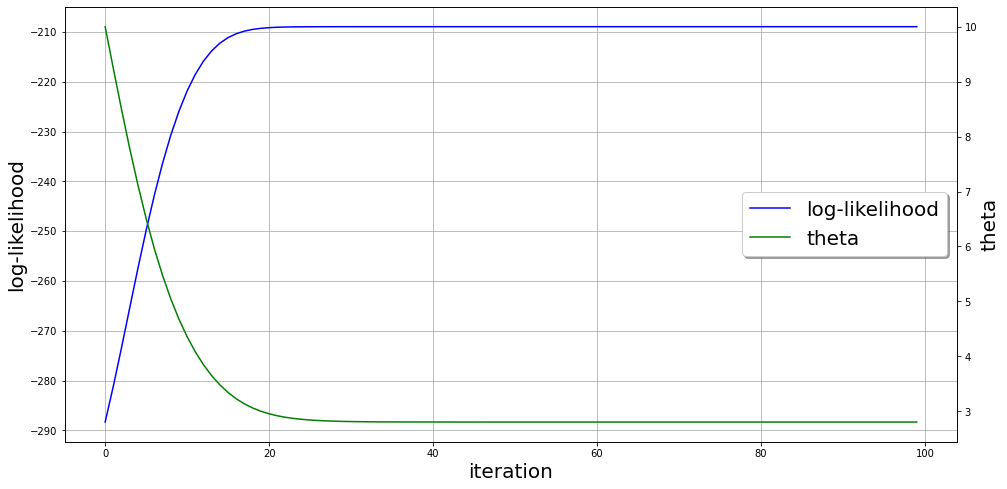

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(log_likelihood, label='log-likelihood', c='b')
ax1.set_xlabel('iteration', fontsize=20)
ax1.set_ylabel('log-likelihood', fontsize=20)
ax1.grid()

ax2.plot(theta_history, label='theta', c='g')
ax2.set_ylabel('theta', fontsize=20)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, fontsize=20, loc='center right', frameon=True, shadow=True)
plt.show()

In [ ]:
beta = 100.0
kernel = rbf_k
mu_test, sigma_test = predict(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)

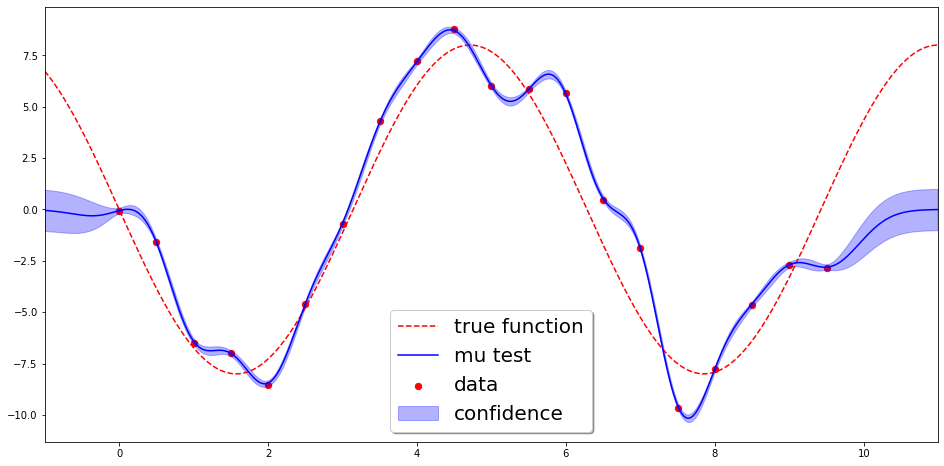

In [ ]:
plot_result()

Сравните этот график с графиком для $\theta=1$. Что произошло с мат. ожиданием? Как изменился параметр $\theta$?  
(_пункт не оценивается_)

Матожидание стало точнее и плавнее проходить через точки наблюдений, однако немного увеличилась дисперсия прогноза. В целом графики во многом похожи.Учитывая, что использовалось ядро RBF, то т. к. неуверенность прогнозов немного возросла, то значение $\theta$ могло немного уменьшиться.

## Оптимизация с помощью Гауссовского процесса

С помощью Гауссовского процесса можно решать задачи black-box оптимизации. То есть, оптимизировать функцию, вид которой нам не известен и нет никакой дополнительной информации, кроме её значений в некоторых точках. Такой метод оптимизации может использоваться для поиска экстремумов некоторой функции, которую очень дорого вычислять, а градиенты этой функции мы и вовсе не можем рассчитать.

Концепция такого алгоритма оптимизации следующая:
1. Настраиваем параметры Гауссовского процесса для имеющегося набора точек.
2. В каждой точке пространства $x$ мы можем посчитать величину expected improvement:
$$\text{EI}(x) = \mathbb{E}_{y(x)}\max(0,t_{\min} - y(x)),$$
где $t_{\min}$ – минимальное значение целевой переменной на уже имеющейся выборке.  
На практике же, мы не можем посчитать expected improvement в каждой точке пространства, но мы можем оптимизировать эту функцию относительно $x$ методами первого или второго порядка и найти локальный максимум этой функции.
3. В качестве новой точки выбираем $x^* = \text{argmax}\; \text{EI}(x)$ и рассчитываем значение $t^*$ в этой точке. После чего добавляем эту точку к нашим данным и возвращаемся к шагу 1.

Сгенерируем выборку

In [ ]:
def f(x):
    return -1/np.sqrt(2*np.pi*0.25)*np.exp(-0.5/0.09*(x-4)**2)-1/np.sqrt(2*np.pi*1.0)*np.exp(-0.5/1.0*(x-8)**2)

support = np.arange(0.95,11.1,1e-2)

In [ ]:
X_train = np.arange(2.0,10.0,3.0)
X_train = X_train + (2.*np.random.rand(len(X_train))-1.)
X_train = X_train.reshape([len(X_train), -1])
Y_train = f(X_train)
T_train = Y_train

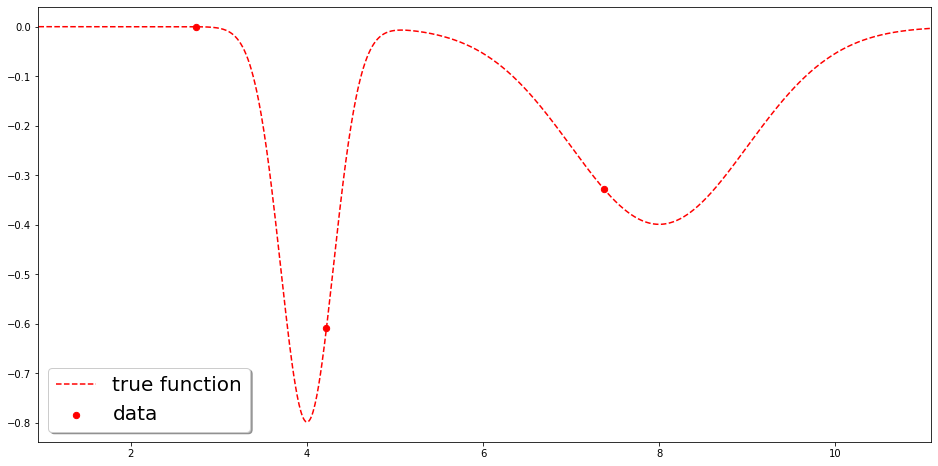

In [ ]:
figsize(16,8)
plt.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
plt.plot(support, f(support), '--r', label='true function')
plt.legend(fontsize=20, frameon=True, shadow=True)
plt.xlim(np.min(support), np.max(support))
plt.show()

**3.** Выведите формулу для expected improvement.

$y(x)$-настраиваемый гауссовский процесс, $\mu(x), \sigma^2(x)$-его параметры (рассматриваем одномерный случай). Выведем формулу $EI(x)$, в рассчетах при интегрировании воспользуемся заменой $s(x)=\frac{y(x)-\mu(x)}{\sigma(x)}$, свойствами интеграла с переменным верхним пределом, и фактом того, что $\frac{\partial}{\partial x}\mathcal{N}(x \mid 0, 1)=-\frac{x}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$:

$EI(x)=\mathbb{E}_{y(x)} \max(0, t_{min}-y(x))=\int_{-\infty}^{+\infty} \max(0, t_{min}-y(x) )p(y(x))dy(x)=\int_{-\infty}^{t_{min}}(t_{min}-y(x))p(y(x))dy(x)=\\=\int_{-\infty}^{t_{min}}(t_{min}-y(x))\frac{1}{\sqrt{2\pi}\sigma(x)}e^{-\frac{(y(x)-\mu(x))^2}{2\sigma^2(x)}}dy(x)=\int_{-\infty}^{\frac{t_{min}-\mu(x)}{\sigma(x)}}(t_{min}-\sigma(x)s(x)-\mu(x))\frac{1}{\sqrt{2\pi}}e^{-\frac{s^2(x)}{2}}ds(x)=\\=\int_{-\infty}^{\frac{t_{min}-\mu(x)}{\sigma(x)}}(t_{min}-\mu(x))\frac{1}{\sqrt{2\pi}}e^{-\frac{s^2(x)}{2}}ds(x)-\int_{-\infty}^{\frac{t_{min}-\mu(x)}{\sigma(x)}}\frac{\sigma(x)s(x)}{\sqrt{2\pi}}e^{-\frac{s^2(x)}{2}}ds(x)=\\=(t_{min}-\mu(x))\Phi\left(\frac{t_{min}-\mu(x)}{\sigma(x)}\right)+\sigma(x)\mathcal{N}\left(\frac{t_{min}-\mu(x)}{\sigma(x)}\mid 0, 1\right)$

где $\Phi(x)$-функция распределения стандартного нормального распределения, $\mathcal{N}(x \mid 0, 1)$ - плотность стандартного нормального распределения.

**4.** Реализуйте функцию для расчёта expected improvement.

In [ ]:
from scipy import stats

def get_expected_improvement(X_train, T_train, X_test, theta, beta, kernel):
    # your code here
    t_min = np.min(T_train)
    mu, sigma = predict(X_train, T_train, X_test, theta, beta, kernel)
    mu = np.reshape(mu, (mu.shape[0],))
    Phi = stats.norm.cdf((t_min - mu) / sigma, loc=np.zeros(mu.shape), scale=np.ones(sigma.shape))
    prob_density = stats.norm.pdf((t_min - mu) / sigma, loc=np.zeros(mu.shape), scale=np.ones(sigma.shape))
    return (t_min - mu) * Phi + sigma * prob_density

In [ ]:
X_test = support
X_test = X_test.reshape([len(X_test), -1])

In [ ]:
def plot_expected_improvement(X_train, T_train, expected_improvement, predictions, sigma):
    fig, ax1 = plt.subplots(1,1)
    ax2 = ax1.twinx()

    ax1.scatter(X_train.flatten(), T_train.flatten(), label='data', c='r', s=40)
    ax1.plot(support, predictions, label='mean')
    ax1.fill_between(support, predictions-sigma, predictions+sigma, color='b', alpha=0.3, label='uncertainty')
    ax1.plot(support, f(support), '--r', label='true function')
    ax1.grid()

    ax2.plot(support, expected_improvement, label='Expected improvement', c='g')
    ax2.scatter(support[np.argmax(expected_improvement)], np.max(expected_improvement), label='max', c='g', s=40)
    ax2.set_ylabel('Expected improvement', fontsize=20)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, fontsize=10, frameon=True, shadow=True)
    plt.xlim(np.min(support), np.max(support))

In [ ]:
import time
from IPython import display

Запустите процесс оптимизации. Сошёлся ли он в точку минимума? Попробуйте разные значения параметров.  
(_пункт не оценивается_)

Процесс действительно сошелся в точку миниммума, найденная точка соответствует минимуму целевой функции и ярко выраженному максимуму критерия $EI(x)$. Также значения $EI(x)$ высоки в точках, соответствующих другим локальным минимумам оптимизируемой функции, в том числе и при достаточно большой неуверенности прогнозов в таких случаях.

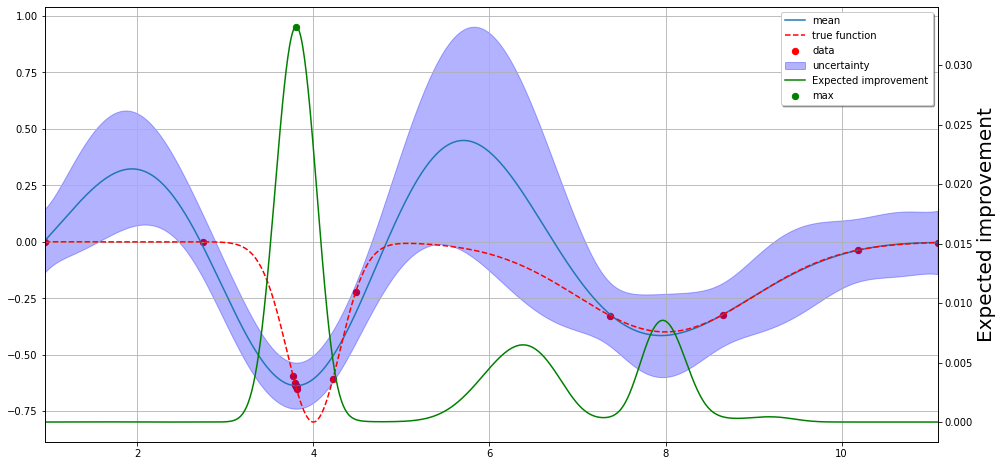

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [ ]:
beta = 100.0
num_tuning_steps = 500
num_new_points = 30
lr = 1e-2
for _ in range(num_new_points):
    plt.clf()
    # model tuning  
    log_theta = np.log(np.array([10.0]))
    for _ in range(num_tuning_steps):
        grad = get_rbf_grad_log_theta(X_train, T_train, np.exp(log_theta), beta)
        log_theta = log_theta + lr*grad
    # calculating expected improvement for all points
    expected_improvement = get_expected_improvement(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)
    mu, sigma = predict(X_train, T_train, X_test, np.exp(log_theta), beta, kernel)
    plot_expected_improvement(X_train, T_train, expected_improvement, np.reshape(mu, (mu.shape[0],)), sigma)
    # adding new point
    X_train = np.vstack([X_train, np.array(support[np.argmax(expected_improvement)])])
    T_train = f(X_train)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
_ = plt.clf()